In [1]:
import cv2
import numpy as np
import pickle
import os
import itertools
import tqdm
import random
from PIL import Image

import sys; sys.path.insert(0, "intermediate_fusion")
from text_preprocessing import Tokenizer, pad_sequences
from gensim.models import KeyedVectors
from gensim.utils import tokenize, simple_preprocess

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import models

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
BASE_DIR = "dataset/"
DATASET_DIR = BASE_DIR + "text_data/"
IMAGES_DIR = BASE_DIR + "images/all_items/"

BATCH_SIZE = 32
TOP_K = 5

In [3]:
def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (256, 256))
  img = img.astype(np.float32) / 255
  return np.moveaxis(img, 2, 0)

def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)

In [4]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
item_to_rooms_map = {item_url.split("/")[-1].split(".jpg")[0] : val for item_url, val in item_to_rooms_map.items()}
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

room_to_items = {}

for item_url, room_url_list in item_to_rooms_map.items():
  item_id = item_url.split("/")[-1].split(".jpg")[0]
  if not os.path.exists(IMAGES_DIR + item_id + ".jpg"):
      print(item_url + " does not exist")
      continue

  for room_url in room_url_list:
    room_id = room_url.split("/")[-1].split(".jpg")[0]
    if room_id not in room_to_items:
      room_to_items[room_id] = [item_id]
    else:
      room_to_items[room_id].append(item_id)
    
with open(BASE_DIR + "train_sets_reweighted.pkl", "rb") as file:
    train_sets = pickle.load(file)
with open(BASE_DIR + "val_data_reweighted.pkl", "rb") as file:
    val_pairs, y_val = pickle.load(file)
with open(BASE_DIR + "preprocessed_text.pkl", "rb") as file:
    item_to_info = pickle.load(file)

890.333.75 does not exist
991.333.98 does not exist
990.612.97 does not exist


In [5]:
with open("dataset/val_data_reweighted.pkl", "rb") as file:
    val_pairs, y_val = pickle.load(file)
    
val_products = set([x for pair in val_pairs for x in pair])
# val_id_indexes = [i for i, id in enumerate(image_ids) if id in val_products]
val_image_ids = sorted(val_products)
# val_image_ids = [image_ids[i] for i in val_id_indexes]
# val_embeddings = [emb[val_id_indexes] for emb in embs]

# Evaluation Setup

In [6]:
import math
class Evaluator:
    def __init__(self, GroundTruth):
      self.GroundTruth = GroundTruth

    def NDCG_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      DCGScore = 0
      result = []
      for i, item in enumerate(sortedRankResult[:topk]):
        if item[0] in self.GroundTruth:
          result.append((item, i))
      DCGScore = sum([item[0][1]/math.log(item[1]+2, 2) for item in result])
      IDCGScore = sum([1/math.log(i+2,2) for i in range(topk)])
      NDCG = DCGScore / IDCGScore

      return NDCG
    
    def Score_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      return sum(i[1] for i in sortedRankResult[:topk] if i[0] in self.GroundTruth) / topk
    
    def Precision(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(topkresult)

    def Recall(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(self.GroundTruth)
    
    def FValue(self, rankresult, topk):
      precision = self.Precision(rankresult, topk)
      recall = self.Recall(rankresult, topk)
      return 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

In [7]:
def confidence_interval(arr):
    sem = arr.std() / np.sqrt(len(arr))
    return arr.mean() - 1.96 * sem, arr.mean() + 1.96 * sem

Text(0.5, 1.0, '6245')

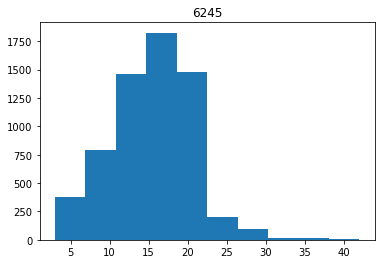

In [8]:
triplet_pairs = []
triplet_ground_truths = []
for pair in (val_pairs[i] for i in np.argwhere(y_val).flatten()):
    triplet_pairs.append(pair)
    gt = set()
    for room_url in item_to_rooms_map[pair[0]]:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        if pair[1] in room_to_items[room_id]:
            gt |= set(room_to_items[room_id])
    triplet_ground_truths.append(gt)

plt.hist([len(x) for x in triplet_ground_truths])
plt.title(len(triplet_pairs))

In [9]:
preprocessed_categories = [set(simple_preprocess(item_categories[o])) for o in val_image_ids]
def eligible_product_indexes(product_idx, cutoff=0.5):
    cat = preprocessed_categories[product_idx]
    cat_sims = [len(x & cat) / max(1, len(x | cat)) for x in preprocessed_categories]
    return [i for i, sim in enumerate(cat_sims) if sim > cutoff]

query_products = {val_image_ids[i]: [val_image_ids[j] for j in eligible_product_indexes(i)]
                  for i in range(len(val_image_ids)) if len(eligible_product_indexes(i)) > 10}
print(len(query_products))
query, candidates = list(query_products.items())[np.random.randint(0, len(query_products))]
print(item_categories[query])
print(', '.join([item_categories[cand] for cand in candidates]))

97
Door
Door, Door, Door, Door, Door, Door, Door, Door, Door, Door, Door, Door, Door, Door


# Loading Data Option 1: Embeddings

This should be used if the model uses a simple similarity metric between embeddings to predict compatibility.

In [ ]:
emb_image_ids, embs = zip(*pickle.load(open("vae/multimodal_vae_embeddings.pickle", "rb")))
val_embeddings = np.stack([embs[emb_image_ids.index(id)] for id in val_image_ids], axis=0)
results = 1 / (1 + np.exp(-np.dot(val_embeddings, val_embeddings.T)))
results.shape

# Loading Data Option 2: Binary Classifier

This should be used if the model has a binary classifier that takes two embeddings and predicts compatibility.

## Generating classifications

Use these cells if you have a set of embeddings and a classifier model you want to run on all pairs of embeddings.

In [ ]:
class OutputClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(OutputClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, first_embs, second_embs):
        output = torch.cat([first_embs, second_embs], 1) # (emb_1 * emb_2).sum(1)
        output = self.fc1(output)
        output = self.dropout1(output)
        output = F.relu(output)
        output = self.fc2(output)
        return output

In [ ]:
all_embs = []
emb_product_ids = None
emb_paths = ["intermediate_fusion_reweighted/embeddings_0.p",
            "intermediate_fusion_reweighted/embeddings_1.p",
            "intermediate_fusion_reweighted/embeddings_2.p"]
checkpoint_paths = ["intermediate_fusion_reweighted/base_0_checkpoint_classifier.p",
                   "intermediate_fusion_reweighted/base_1_checkpoint_classifier.p",
                   "intermediate_fusion_reweighted/base_2_checkpoint_classifier.p"]
# # emb_paths = ["intermediate_fusion_reweighted/text_only_embeddings.p"]
# # checkpoint_paths = ["intermediate_fusion_reweighted/text_only_checkpoint_classifier.p"]

for path in emb_paths:
    with open(path, "rb") as file:
        new_product_ids, embs = pickle.load(file)
    if emb_product_ids is not None: assert new_product_ids == emb_product_ids
    else: emb_product_ids = new_product_ids
    all_embs.append(embs)

# For now just take the first one
embs = all_embs[0]
path = checkpoint_paths[0]
embs.shape

In [ ]:
# embs = ... # matrix of embeddings for all products
model = OutputClassifier(256, 1) # a classification model that takes two arguments: a batch of "first" embeddings and a batch of "second" embeddings
state = torch.load(path, map_location=torch.device('cpu'))
model.load_state_dict(state)

emb_product_idx_mapping = {id: i for i, id in enumerate(emb_product_ids)}

combs = list(itertools.product(range(len(val_image_ids)), range(len(val_image_ids))))
print(len(combs), "pairs for", len(val_image_ids), "products")

def make_batches(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
        
results_list = []
with torch.no_grad():
    for batch in tqdm.tqdm(make_batches(combs, 32), total=len(combs) // 32 + 1):
        first_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[0]]]] for x in batch]))
        second_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[1]]]] for x in batch]))
        results_list.append(model(first_embs, second_embs).cpu().numpy())
results = np.concatenate(results_list).reshape(len(val_image_ids), len(val_image_ids))
results = 1 / (1 + np.exp(-results)) # optional sigmoid transformation (if not applied by model)

## Reading classifications from file 

Use this if you *already* have the `results` variable stored in a file, and you just want to read it.

In [10]:
results = np.load("co_learning_results.npy")
results.shape

(680, 680)

# Evaluation

## Single query

In [11]:
# Ranking metrics
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

ndcg = np.zeros(len(val_products))
score = np.zeros(len(val_products))
precision = np.zeros(len(val_products))
recall = np.zeros(len(val_products))
fvalue = np.zeros(len(val_products))
for i, (ground_truth, sim_row) in enumerate(zip(ground_truth_lists, results)):
    evaluator = Evaluator(ground_truth)
    rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product != val_image_ids[i]}
    ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
    score[i] = evaluator.Score_Eval(rankings, TOP_K)
    precision[i] = evaluator.Precision(rankings, TOP_K)
    recall[i] = evaluator.Recall(rankings, TOP_K)
    fvalue[i] = evaluator.FValue(rankings, TOP_K)
print("Single query results:")
print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), *confidence_interval(ndcg)))
print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), *confidence_interval(score)))
print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), *confidence_interval(precision)))
print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), *confidence_interval(recall)))
print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), *confidence_interval(fvalue)))
print("")

Single query results:
NDCG: 0.0198 (95% CI 0.015-0.025)
Score: 0.0188 (95% CI 0.014-0.024)
Precision: 0.0218 (95% CI 0.016-0.027)
Recall: 0.0047 (95% CI 0.003-0.006)
FValue: 0.0074 (95% CI 0.006-0.009)



In [12]:
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

scores = []
ground_truth_objects = []
score_query_idxs = []
print(results.shape, len(ground_truth_lists))
for i, (ground_truth, sim_row) in enumerate(zip(ground_truth_lists, results)):
    for gt_item in ground_truth:
        if gt_item not in query_products: continue
        ground_truth_objects.append(gt_item)
        score_query_idxs.append(i)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                    if product != val_image_ids[i] and product in query_products[gt_item]}
        top_items = set(sorted(rankings, key=rankings.get, reverse=True)[:TOP_K])
        scores.append(gt_item in top_items)
print("Category-limited recall@{}: {:.3f} ({} total queries)".format(TOP_K, np.mean(scores), len(scores)))

(680, 680) 680
Category-limited recall@5: 0.407 (670 total queries)


## Double query

In [13]:
val_image_index = {id: i for i, id in enumerate(val_image_ids)}

ndcg = np.zeros(len(triplet_pairs))
score = np.zeros(len(triplet_pairs))
precision = np.zeros(len(triplet_pairs))
recall = np.zeros(len(triplet_pairs))
fvalue = np.zeros(len(triplet_pairs))

for i, (pair, ground_truth) in enumerate(zip(triplet_pairs, triplet_ground_truths)):
    sim_row = np.mean(np.vstack([results[val_image_index[pair[0]]],
                                 results[val_image_index[pair[1]]]]), axis=0)

    evaluator = Evaluator(ground_truth)
    rankings = {product: output for product, output in zip(val_image_ids, sim_row) if product not in pair}
    ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
    score[i] = evaluator.Score_Eval(rankings, TOP_K)
    precision[i] = evaluator.Precision(rankings, TOP_K)
    recall[i] = evaluator.Recall(rankings, TOP_K)
    fvalue[i] = evaluator.FValue(rankings, TOP_K)

print("Double query results:")
print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))
print("")

Double query results:
NDCG: 0.0126 (95% CI -0.083-0.108)
Score: 0.0126 (95% CI -0.077-0.102)
Precision: 0.0154 (95% CI -0.093-0.124)
Recall: 0.0043 (95% CI -0.028-0.036)
FValue: 0.0067 (95% CI -0.042-0.055)



In [14]:
ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in val_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] - set([item_id]) for item_id in val_image_ids]

scores = []
ground_truth_objects = []
score_query_idxs = []
print(results.shape, len(ground_truth_lists))
for i, (pair, ground_truth) in enumerate(zip(triplet_pairs, triplet_ground_truths)):
    sim_row = np.amin(np.vstack([results[val_image_index[pair[0]]],
                                 results[val_image_index[pair[1]]]]), axis=0)

    for gt_item in ground_truth:
        if gt_item in pair or gt_item not in query_products: continue
        ground_truth_objects.append(gt_item)
        score_query_idxs.append(i)
        rankings = {product: output for product, output in zip(val_image_ids, sim_row)
                    if product not in pair and product in query_products[gt_item]}
        top_items = set(sorted(rankings, key=rankings.get, reverse=True)[:TOP_K])
        scores.append(gt_item in top_items)
print("Category-limited pair recall@{}: {:.3f} ({} total queries)".format(TOP_K, np.mean(scores), len(scores)))

(680, 680) 680
Category-limited pair recall@5: 0.406 (3338 total queries)


## Accuracy and AUC Score

In [15]:
pred = np.array([results[val_image_ids.index(pair[0]), val_image_ids.index(pair[1])] for pair in val_pairs])
print("Validation accuracy: {:.3f}".format(np.mean(np.round(pred) == y_val)))
print("AUC: {:.3f}".format(roc_auc_score(y_val, pred)))

Validation accuracy: 0.551
AUC: 0.591


# Embedding Comparison

In [16]:
import emblaze

In [33]:
all_embeddings = [list(zip(*pickle.load(open("vae/multimodal_vae_embeddings.pickle", "rb"))))]
all_embeddings[0][1] = np.stack(all_embeddings[0][1], axis=0)
all_embeddings.append(pickle.load(open("intermediate_fusion_embeddings/embeddings_0.p", "rb")))
all_embeddings.append(pickle.load(open("intermediate_fusion_controls/embeddings_text_only.p", "rb")))
# all_embeddings.append(pickle.load(open("naive_clip/untuned_CLIP_embeddings.pkl", "rb")))
all_embeddings.append((
    val_image_ids,
    np.concatenate([np.load("co_learning/img_embs.npy"), np.load("co_learning/text_embs.npy")], axis=1)
))

image_ids = sorted(set.intersection(*(set(x[0]) for x in all_embeddings)))
embs = [emb[[ids.index(id) for id in image_ids]] for ids, emb in all_embeddings]
print(len(image_ids))

680


In [42]:
from collections import Counter
labels = [item_categories[id].split()[-1].lower() for id in val_image_ids]
cutoff = 10
label_counts = Counter(labels)
print(len([l for l in label_counts if label_counts[l] > cutoff]))
labels = [l if label_counts[l] > cutoff else "other" for l in labels]

15


In [36]:
embeddings = emblaze.EmbeddingSet([
    emblaze.Embedding({
        emblaze.Field.POSITION: emb,
        emblaze.Field.COLOR: labels
    }, label=label, metric='cosine') for emb, label in zip(embs,
                                          ['VAE', 'IF', 'Text', 'Co-Learning'])
])
embeddings

Embeddings are not 2D, skipping alignment


<EmbeddingSet with 4 embeddings:
	<Embedding with 680 items, 2 fields (position, color)>
	<Embedding with 680 items, 2 fields (position, color)>
	<Embedding with 680 items, 2 fields (position, color)>
	<Embedding with 680 items, 2 fields (position, color)>>

In [37]:
embeddings.compute_neighbors(n_neighbors=100)

In [38]:
reduced = embeddings.project(method=emblaze.ProjectionTechnique.ALIGNED_UMAP)
reduced

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/vsivaram/anaconda3/envs/mmml/lib/python3.9/site-packages/umap/umap_.py:905: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


<EmbeddingSet with 4 embeddings:
	<Embedding with 680 items, 3 fields (position, color, highlight)>
	<Embedding with 680 items, 3 fields (position, color, highlight)>
	<Embedding with 680 items, 3 fields (position, color, highlight)>
	<Embedding with 680 items, 3 fields (position, color, highlight)>>

In [39]:
images = [np.array(Image.open("dataset/images/all_items/" + id + ".jpg").resize((224, 224)))
          for id in image_ids]
img_thumbnails = emblaze.ImageThumbnails(images)
text_thumbnails = emblaze.TextThumbnails([item_categories[id] for id in image_ids])
thumbnails = emblaze.CombinedThumbnails([img_thumbnails, text_thumbnails])

In [43]:
for emb in reduced.embeddings:
    emb.set_field(emblaze.Field.COLOR, labels)

In [ ]:
w = emblaze.Viewer(embeddings=reduced, thumbnails=thumbnails)
w

Viewer(colorScheme='tableau', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 680, 'ids':…

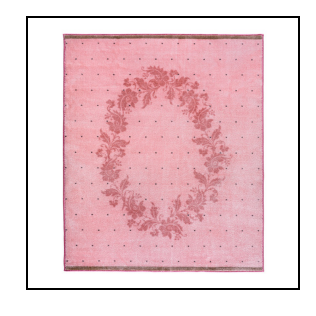

In [51]:
plt.figure(figsize=(2, 2), dpi=180)
plt.imshow(Image.open("dataset/images/all_items/" + image_ids[w.selectedIDs[0]] + ".jpg"))
plt.xticks([])
plt.yticks([])
plt.show()